<a href="https://colab.research.google.com/github/oimartin/dog_cat_redux_kernelED/blob/main/reading_in_image_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

## Libraries

In [1]:
import os, cv2, random, shutil
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.output import eval_js
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from time import time
from keras.models import Sequential
from keras import layers
from keras.losses import BinaryCrossentropy, Poisson, SparseCategoricalCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

from sklearn.metrics import log_loss, brier_score_loss, PrecisionRecallDisplay, RocCurveDisplay, roc_curve

## Load Data with Kaggle API
[*Kaggle API doc*](https://www.kaggle.com/general/74235)

In [2]:
eval_js('google.colab.output.setIframeHeight("500")')

uploaded = files.upload()
!mkdir /root/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!mkdir train_img
!mkdir test_img
!mkdir train_subset
!unzip train.zip -d train_img
!unzip test.zip -d test_img/

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test/5499.jpg  
  inflating: test_img/test/55.jpg    
  inflating: test_img/test/550.jpg   
  inflating: test_img/test/5500.jpg  
  inflating: test_img/test/5501.jpg  
  inflating: test_img/test/5502.jpg  
  inflating: test_img/test/5503.jpg  
  inflating: test_img/test/5504.jpg  
  inflating: test_img/test/5505.jpg  
  inflating: test_img/test/5506.jpg  
  inflating: test_img/test/5507.jpg  
  inflating: test_img/test/5508.jpg  
  inflating: test_img/test/5509.jpg  
  inflating: test_img/test/551.jpg   
  inflating: test_img/test/5510.jpg  
  inflating: test_img/test/5511.jpg  
  inflating: test_img/test/5512.jpg  
  inflating: test_img/test/5513.jpg  
  inflating: test_img/test/5514.jpg  
  inflating: test_img/test/5515.jpg  
  inflating: test_img/test/5516.jpg  
  inflating: test_img/test/5517.jpg  
  inflating: test_img/test/5518.jpg  
  inflating: test_img/test/5519.jpg  
  inflating: test_img/test/552.jpg   

# EDA
*Inspired by Jeff Delaney notebook: https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter*

## First Look at Data


In [4]:
"""
Get directory path for all images, just dogs, and just cats
"""
def get_images (directory, type=None):
    if type is None:
        images = [directory + i for i in os.listdir(directory)]
        print(f"There are {len(images)} images")
    else:
        images = [directory + i for i in os.listdir(directory) if type in i]
        print(f"There are {len(images)} {type} images")
    return images

train = '/content/train_img/train/'
test = '/content/test_img/test/'

train_images = get_images(train)
train_dogs = get_images(train, 'dog')
train_cats = get_images(train, 'cat')

test_images = get_images(test)

There are 25000 images
There are 12500 dog images
There are 12500 cat images
There are 12500 images


## First View of Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7fe9b9af7410>,
 [Text(0, 0, 'Dog_pic'), Text(0, 0, 'Cat_pic')])

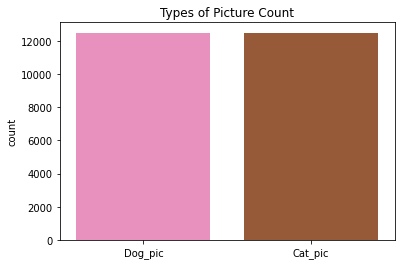

In [5]:
# Create cat/dog label list
labels = []
for img_name in train_images:
    if 'dog' in img_name:
        labels.append(1)
    else:
        labels.append(0)

# View label distribution
sns.set_palette('Set1_r')
sns.countplot(labels).set(title='Types of Picture Count')
plt.xticks(ticks=[0,1], labels=['Dog_pic', 'Cat_pic'])

## Processing Data

In [6]:
train_img_label = []
for i in range(0,len(labels)):
  pair = (train_images[i], labels[i])
  train_img_label.append(pair)

train_img_label

[('/content/train_img/train/cat.7869.jpg', 0),
 ('/content/train_img/train/dog.6453.jpg', 1),
 ('/content/train_img/train/cat.2782.jpg', 0),
 ('/content/train_img/train/dog.8970.jpg', 1),
 ('/content/train_img/train/cat.6347.jpg', 0),
 ('/content/train_img/train/dog.3883.jpg', 1),
 ('/content/train_img/train/cat.10695.jpg', 0),
 ('/content/train_img/train/dog.11431.jpg', 1),
 ('/content/train_img/train/cat.3289.jpg', 0),
 ('/content/train_img/train/cat.9126.jpg', 0),
 ('/content/train_img/train/dog.9576.jpg', 1),
 ('/content/train_img/train/dog.612.jpg', 1),
 ('/content/train_img/train/cat.11494.jpg', 0),
 ('/content/train_img/train/cat.12207.jpg', 0),
 ('/content/train_img/train/dog.4285.jpg', 1),
 ('/content/train_img/train/cat.3868.jpg', 0),
 ('/content/train_img/train/dog.11218.jpg', 1),
 ('/content/train_img/train/dog.2155.jpg', 1),
 ('/content/train_img/train/cat.6718.jpg', 0),
 ('/content/train_img/train/cat.12071.jpg', 0),
 ('/content/train_img/train/dog.9970.jpg', 1),
 ('/cont

In [13]:
# Randomly select dog and cat images to make subset of training images
train_images = random.sample(train_img_label, 50)
sample_size = len(train_images)

hmm = train_images[0][0]
display(hmm[24:])

for file in train_images:
  shutil.copy(file[0], f"/content/train_subset/{file[0][24:]}")

'/dog.5591.jpg'

In [14]:
# Define parameters for images to be processed
ROWS = 75
COLS = 75
CHANNELS = 3

In [15]:
"""
Reshape image

"""
def read_image (file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return (cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC))

def prep_data(images, test=False):
    count = len(images)
    
    if test is False:
      df = []
      for i, image_label in enumerate(images):

          image = read_image(image_label[0])
          df.append([np.array(image),image_label[1]])
      return df
    elif test is True:
      df = []
      for i, image_label in enumerate(images):
          image = read_image(image_label)
          df.append([np.array(image),image_label[23:]])
      return df

train = prep_data(train_images)
print(f"type train: {type(train)}, length:{len(train)}")

test = prep_data(test_images, True)
print(f"type test: {type(test)}, length:{len(test)}")


type train: <class 'list'>, length:50
type test: <class 'list'>, length:12500


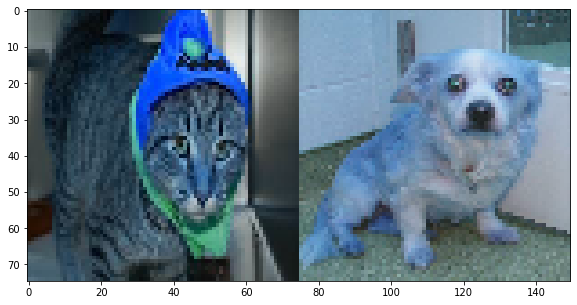

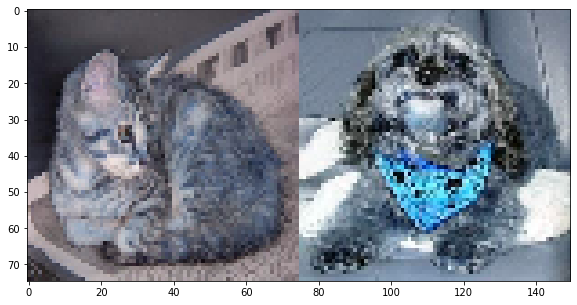

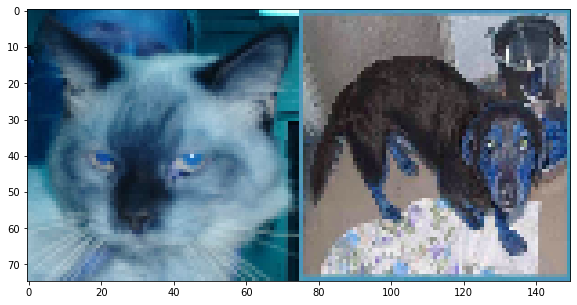

In [ ]:
"""
Display images next to each other for certain cat and dog
"""
def show_cats_and_dogs(no, test=False):
  if test is False:
    cat = read_image(train_cats[no])
    dog = read_image(train_dogs[no])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair, cmap='gray')
    plt.show()

  elif test is True:
    test = read_image(test_images[no])
    plt.figure(figsize=(10,5))
    plt.imshow(test, cmap='gray')
    plt.show()
  return
  
for img_id in range(6,9):
    show_cats_and_dogs(img_id)

In [ ]:
# dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
# plt.imshow(dog_avg, cmap='gray')
# plt.title('Your Average Dog')

In [ ]:
# cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
# plt.imshow(cat_avg, cmap='gray')
# plt.title('Your Average Cat')

# Split Data

In [ ]:
# Prepare the train data
X = np.array([i[0] for i in train]).reshape(-1,ROWS,COLS,CHANNELS)
y = np.array([i[1] for i in train])
test_X = np.array([i[0] for i in test]).reshape(-1,ROWS,COLS, CHANNELS)

In [ ]:
# normalize our data in 0-1
training = X/255
testing = test_X/255

In [ ]:
display(training.shape, testing.shape)

(50, 75, 75, 3)

(12500, 75, 75, 3)

In [ ]:
X_train, X_test, labels_train, labels_test = train_test_split(training,
                                                                y[:sample_size],
                                                                test_size=0.2,
                                                                random_state=22)

print(f'''X_train shape {X_train.shape}
labels_train shape {len(labels_train)}
X_test shape {X_test.shape}
labels_test {len(labels_test)}
''')

X_train shape (40, 75, 75, 3)
labels_train shape 40
X_test shape (10, 75, 75, 3)
labels_test 10



# CNN Models

### Model Functions

In [ ]:
def run_model (model, model_name):
  callback = EarlyStopping(monitor='loss', patience=2)
  start = time()
  fitted_model = model.fit(X_train,
                           labels_train,
                           callbacks=[callback])
  end = time()
  runtime = round((end-start), 4)
  print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return runtime

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  classes_x = np.argmax(pred,axis=1)
  return pred

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['bsl', 'log_loss'],
                   'metric' : [round(brier_score_loss(y_true, y_prob), 4),
                               round(log_loss(y_true, y_prob), 4)]})
  display(df)
  return df

def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')

  f, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax0, 
                                   name=f'{model_name} {train_test} ROC_Curve')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax1, 
                                          name=f'{model_name} {train_test} Precision/Recall')
  plt.savefig(f'{model_name}_{train_test}_roc_prec_rec_curves.png')
  plt.show()
  return

def submitted (fitted_model, model_name, test=test):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'label'}).astype('float64')
  df.index += 1
  df['id'] = df.index
  df = df[['id', 'label']]
  df.to_csv(f"{model_name}_pred.csv", index=False)
  return df

### Test Data

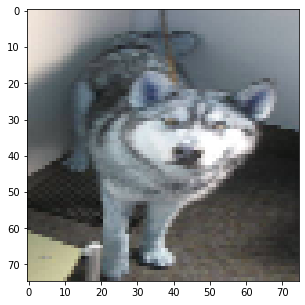

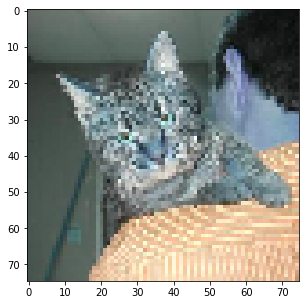

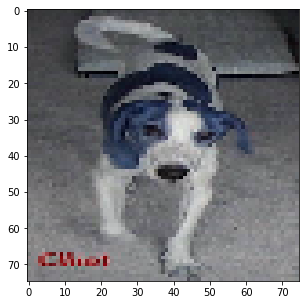

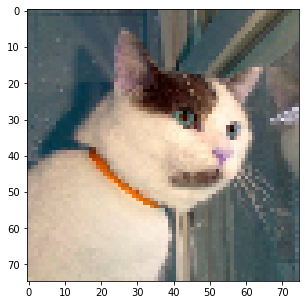

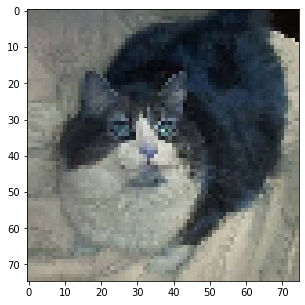

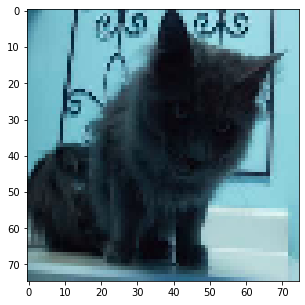

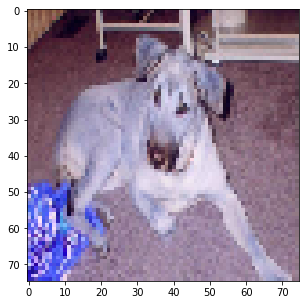

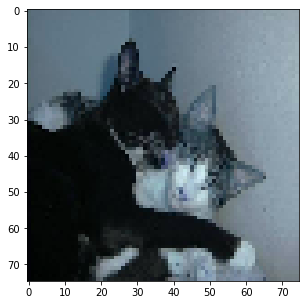

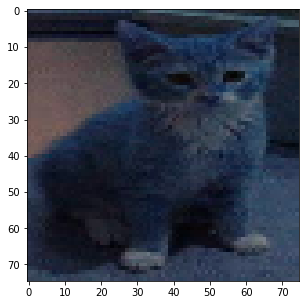

In [ ]:
for img_id in range(0,9):
    show_cats_and_dogs(img_id, True)

## Model 1

In [ ]:
cnn1 = Sequential([
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu',
                  input_shape=(ROWS, COLS, CHANNELS)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(ROWS, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid"),
])
cnn1.compile(optimizer="SGD", loss=BinaryCrossentropy(),
                    metrics=['accuracy'])

In [ ]:
cnn1_rt = run_model(cnn1, 'cnn1') 
train_prob_cnn1 = prediction(cnn1, X_train)
test_prob_cnn1 = prediction(cnn1, X_test)

2/2 [==============================] - 2s 140ms/step - loss: 0.6925 - accuracy: 0.4750
cnn_2d21_d105 took 1.8665 seconds or 0.0311 minutes to run.


### Evaluate First CNN Model

In [ ]:
train_prob_cnn1

array([[0.52831876],
       [0.52713776],
       [0.5001706 ],
       [0.50691617],
       [0.5073989 ],
       [0.51815605],
       [0.5143889 ],
       [0.52091515],
       [0.5257274 ],
       [0.51196164],
       [0.52639484],
       [0.5064982 ],
       [0.50688684],
       [0.5053416 ],
       [0.5225091 ],
       [0.5096295 ],
       [0.50847787],
       [0.48945802],
       [0.51007164],
       [0.5143632 ],
       [0.51822287],
       [0.5049653 ],
       [0.5145677 ],
       [0.4658955 ],
       [0.49481627],
       [0.50592184],
       [0.5152143 ],
       [0.48655874],
       [0.5169731 ],
       [0.5139723 ],
       [0.5221623 ],
       [0.5264804 ],
       [0.5227925 ],
       [0.5193208 ],
       [0.49582672],
       [0.51130056],
       [0.5079579 ],
       [0.51159865],
       [0.5289385 ],
       [0.509547  ]], dtype=float32)

,model_name,type,metric_name,metric
0,cnn1,Train,bsl,0.2429
1,cnn1,Train,log_loss,0.6790



  cnn1 for Train Data
  FPR [0.         0.         0.         0.06666667 0.06666667 0.2
 0.2        0.26666667 0.26666667 0.4        0.4        0.6
 0.6        0.66666667 0.66666667 1.        ]
  TPR [0.   0.04 0.12 0.12 0.28 0.28 0.32 0.32 0.36 0.36 0.84 0.84 0.88 0.88
 1.   1.  ]
  


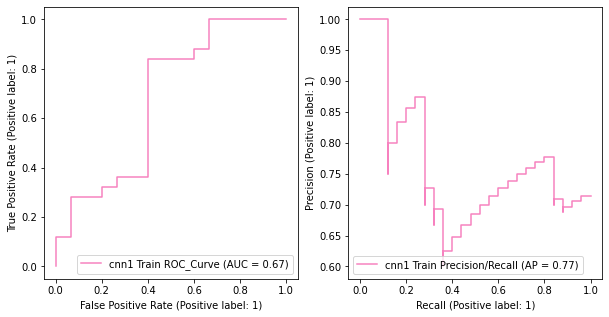

---------------------


,model_name,type,metric_name,metric
0,cnn1,Test,bsl,0.2590
1,cnn1,Test,log_loss,0.7112



  cnn1 for Test Data
  FPR [0.         0.14285714 0.57142857 0.57142857 0.85714286 0.85714286
 1.        ]
  TPR [0.         0.         0.         0.66666667 0.66666667 1.
 1.        ]
  


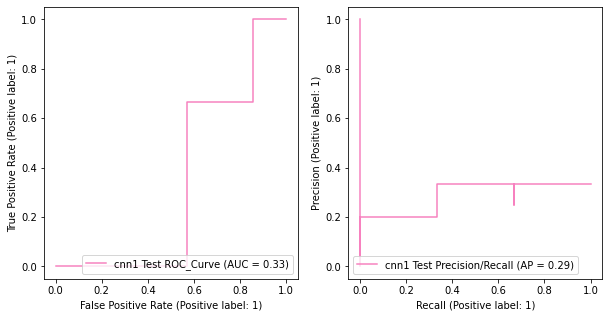

In [ ]:
cnn1_train = prob_eval(labels_train, train_prob_cnn1, 'cnn1', 'Train')
eval_classification(train_prob_cnn1, labels_train, X_train, 'cnn1', 'Train')
print("---------------------")
cnn1_test = prob_eval(labels_test, test_prob_cnn1, 'cnn1', 'Test')
eval_classification(test_prob_cnn1, labels_test, X_test, 'cnn1', 'Test')

### Actual Test Results

In [ ]:
submitted(cnn1, 'cnn1', testing)

,id,label
1,1,0.527730
2,2,0.530164
3,3,0.516745
4,4,0.518271
5,5,0.521824
...,...,...
12496,12496,0.510339
12497,12497,0.504622
12498,12498,0.511796
12499,12499,0.523519


## Model 2

In [ ]:
cnn2 = Sequential([
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu',
                  input_shape=(ROWS, COLS, CHANNELS)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(ROWS, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid"),
])
cnn2.compile(optimizer="SGD", loss=BinaryCrossentropy(),
                    metrics=['accuracy'])

In [ ]:
cnn2_rt = run_model(cnn2, 'cnn2') 
train_prob_cnn2 = prediction(cnn2, X_train)
test_prob_cnn2 = prediction(cnn2, X_test)

2/2 [==============================] - 1s 166ms/step - loss: 0.6786 - accuracy: 0.6250
cnn2 took 1.9915 seconds or 0.0332 minutes to run.


### Evaluate First CNN Model

In [ ]:
train_prob_cnn1

array([[0.52831876],
       [0.52713776],
       [0.5001706 ],
       [0.50691617],
       [0.5073989 ],
       [0.51815605],
       [0.5143889 ],
       [0.52091515],
       [0.5257274 ],
       [0.51196164],
       [0.52639484],
       [0.5064982 ],
       [0.50688684],
       [0.5053416 ],
       [0.5225091 ],
       [0.5096295 ],
       [0.50847787],
       [0.48945802],
       [0.51007164],
       [0.5143632 ],
       [0.51822287],
       [0.5049653 ],
       [0.5145677 ],
       [0.4658955 ],
       [0.49481627],
       [0.50592184],
       [0.5152143 ],
       [0.48655874],
       [0.5169731 ],
       [0.5139723 ],
       [0.5221623 ],
       [0.5264804 ],
       [0.5227925 ],
       [0.5193208 ],
       [0.49582672],
       [0.51130056],
       [0.5079579 ],
       [0.51159865],
       [0.5289385 ],
       [0.509547  ]], dtype=float32)

,model_name,type,metric_name,metric
0,cnn2,Train,bsl,0.2392
1,cnn2,Train,log_loss,0.6715



  cnn2 for Train Data
  FPR [0.         0.         0.06666667 0.06666667 0.26666667 0.26666667
 0.33333333 0.33333333 0.4        0.4        0.53333333 0.53333333
 0.73333333 0.73333333 0.86666667 0.86666667 1.         1.        ]
  TPR [0.   0.04 0.04 0.08 0.08 0.2  0.2  0.28 0.28 0.32 0.32 0.56 0.56 0.64
 0.64 0.72 0.72 1.  ]
  


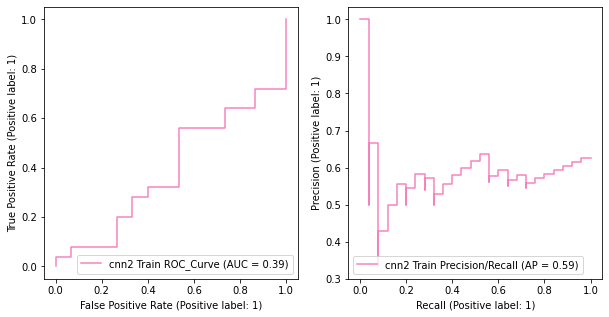

---------------------


,model_name,type,metric_name,metric
0,cnn2,Test,bsl,0.3001
1,cnn2,Test,log_loss,0.7950



  cnn2 for Test Data
  FPR [0.         0.14285714 0.42857143 0.42857143 0.71428571 0.71428571
 1.        ]
  TPR [0.         0.         0.         0.33333333 0.33333333 1.
 1.        ]
  


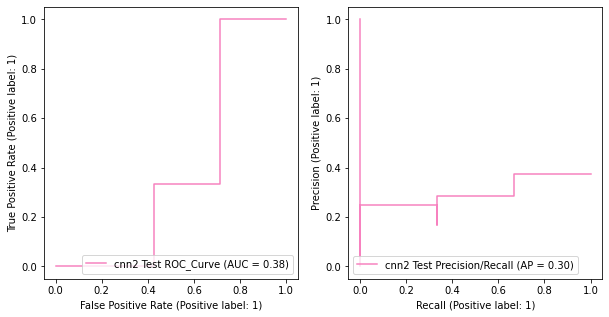

In [ ]:
cnn2_train = prob_eval(labels_train, train_prob_cnn2, 'cnn2', 'Train')
eval_classification(train_prob_cnn2, labels_train, X_train, 'cnn2', 'Train')
print("---------------------")
cnn2_test = prob_eval(labels_test, test_prob_cnn2, 'cnn2', 'Test')
eval_classification(test_prob_cnn2, labels_test, X_test, 'cnn2', 'Test')

### Actual Test Results

In [ ]:
submitted(cnn2, 'cnn2', testing)

,id,label
1,1,0.578838
2,2,0.588751
3,3,0.570499
4,4,0.602969
5,5,0.576218
...,...,...
12496,12496,0.591063
12497,12497,0.579998
12498,12498,0.558671
12499,12499,0.601612


## Model 3

In [ ]:
cnn3 = Sequential([
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu',
                  input_shape=(ROWS, COLS, CHANNELS)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=COLS, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),    
    layers.Dense(ROWS, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid"),
])
cnn3.compile(optimizer="adam", loss=BinaryCrossentropy(),
                    metrics=['accuracy'])

In [ ]:
cnn3_rt = run_model(cnn3, 'cnn3') 
train_prob_cnn3 = prediction(cnn3, X_train)
test_prob_cnn3 = prediction(cnn3, X_test)

2/2 [==============================] - 1s 160ms/step - loss: 0.6977 - accuracy: 0.5750
cnn3 took 2.1058 seconds or 0.0351 minutes to run.


### Evaluate First CNN Model

In [ ]:
train_prob_cnn3

array([[0.5706926 ],
       [0.5920643 ],
       [0.5643438 ],
       [0.5667626 ],
       [0.5518456 ],
       [0.56892306],
       [0.5705351 ],
       [0.5692427 ],
       [0.5868094 ],
       [0.5529767 ],
       [0.58047307],
       [0.5720761 ],
       [0.5862595 ],
       [0.5549939 ],
       [0.5890265 ],
       [0.56225723],
       [0.5681056 ],
       [0.56298316],
       [0.5718684 ],
       [0.54464597],
       [0.5634826 ],
       [0.5635791 ],
       [0.5728975 ],
       [0.58235353],
       [0.56387454],
       [0.568999  ],
       [0.5712201 ],
       [0.5567383 ],
       [0.58170444],
       [0.5741494 ],
       [0.5652499 ],
       [0.57298243],
       [0.56790245],
       [0.5656709 ],
       [0.5624981 ],
       [0.5617211 ],
       [0.5759304 ],
       [0.58907884],
       [0.56050706],
       [0.5629777 ]], dtype=float32)

,model_name,type,metric_name,metric
0,cnn3,Train,bsl,0.2370
1,cnn3,Train,log_loss,0.6669



  cnn3 for Train Data
  FPR [0.         0.         0.         0.2        0.2        0.26666667
 0.26666667 0.33333333 0.33333333 0.46666667 0.46666667 0.53333333
 0.53333333 0.6        0.6        0.66666667 0.66666667 0.8
 0.8        0.86666667 0.86666667 0.93333333 0.93333333 1.
 1.        ]
  TPR [0.   0.04 0.16 0.16 0.28 0.28 0.4  0.4  0.48 0.48 0.6  0.6  0.64 0.64
 0.68 0.68 0.72 0.72 0.76 0.76 0.88 0.88 0.96 0.96 1.  ]
  


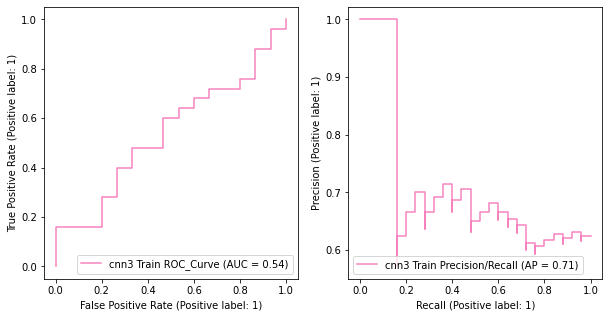

---------------------


,model_name,type,metric_name,metric
0,cnn3,Test,bsl,0.2801
1,cnn3,Test,log_loss,0.7538



  cnn3 for Test Data
  FPR [0.         0.14285714 0.14285714 0.28571429 0.28571429 0.42857143
 0.42857143 1.        ]
  TPR [0.         0.         0.33333333 0.33333333 0.66666667 0.66666667
 1.         1.        ]
  


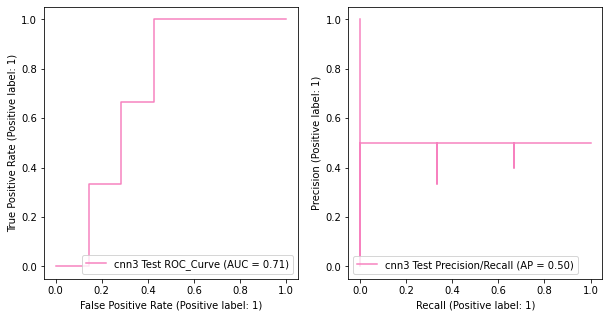

In [ ]:
cnn3_train = prob_eval(labels_train, train_prob_cnn3, 'cnn3', 'Train')
eval_classification(train_prob_cnn3, labels_train, X_train, 'cnn3', 'Train')
print("---------------------")
cnn3_test = prob_eval(labels_test, test_prob_cnn3, 'cnn3', 'Test')
eval_classification(test_prob_cnn3, labels_test, X_test, 'cnn3', 'Test')

### Actual Test Results

In [ ]:
submitted(cnn3, 'cnn3', testing)

,id,label
1,1,0.562045
2,2,0.575640
3,3,0.560710
4,4,0.568745
5,5,0.548313
...,...,...
12496,12496,0.575663
12497,12497,0.565007
12498,12498,0.551799
12499,12499,0.576734
